In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

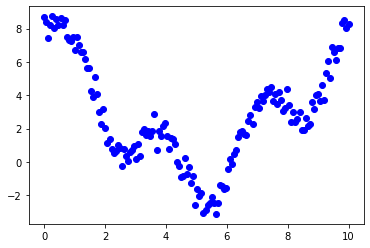

In [2]:
n = 150
X_data = np.linspace(0,10,n)
X_data = X_data.reshape((n,1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 
data_no_noise = np.concatenate((X_data, Y_data), axis=1)

Y_data += np.random.normal(0, 0.5, [n,1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

In [3]:
data = np.concatenate((X_data, Y_data), axis=1)
data_eval = data.copy()

np.random.shuffle(data)

data_tr, data_val, data_test = np.split(data, [int(0.8*n), int(0.8*n)+int(0.1*n)], axis = 0)
print(data_tr.shape, data_val.shape, data_test.shape)
n_tr, n_val, n_test = data_tr.shape[0], data_val.shape[0], data_test.shape[0]

(120, 2) (15, 2) (15, 2)


In [4]:
def next_batch(data_tr, i, batch_size):
    return data_tr[i*batch_size:(i+1)*batch_size-1, :]  

In [65]:
# Parameters
learning_rate = 0.01
num_epochs = 4000
batch_size = n_tr // 1
itpep = n_tr // batch_size
display_step = 100
wd_pars = np.linspace(0, 0.5, 10)

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

In [66]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [67]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer 
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

In [68]:
fp = neural_net(X)

error = tf.reduce_sum(tf.pow(fp-Y, 2))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


Optimization for lambda 0.000000 finished!
Optimization for lambda 0.055556 finished!
Optimization for lambda 0.111111 finished!
Optimization for lambda 0.166667 finished!
Optimization for lambda 0.222222 finished!
Optimization for lambda 0.277778 finished!
Optimization for lambda 0.333333 finished!
Optimization for lambda 0.388889 finished!
Optimization for lambda 0.444444 finished!
Optimization for lambda 0.500000 finished!


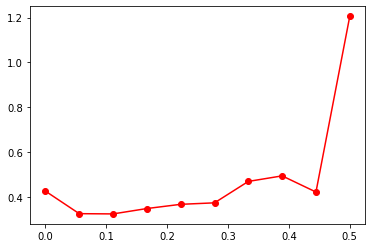

In [69]:
wd_errors = []
opt_weights = []
opt_biases = []

sess = tf.Session()
for wd_par in wd_pars:
    loss = n_tr / batch_size * tf.reduce_sum(tf.pow(fp-Y, 2)) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])
    
    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    #############################################################
    sess.run(init)
    #############################################################
    i = 0

    for iteration in range(num_epochs * itpep):

        data_batch = next_batch(data_tr, i, batch_size)
        sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})

        if (iteration + 1) % itpep == 0:
            i = 0
        else:
            i += 1
    print('Optimization for lambda', '{:.6f}'.format(wd_par), 'finished!')
    
    wd_errors.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}) / data_val.shape[0])
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))
    
plt.plot(wd_pars, wd_errors, 'ro-')
plt.show()

In [70]:
wd_pars


array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])

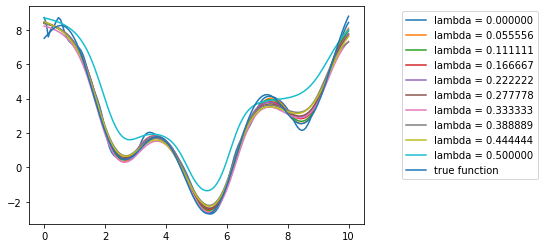

In [71]:
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'lambda = %.6f' %wd_pars[c])
    
plt.plot(data_no_noise[:, [0]], data_no_noise[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()

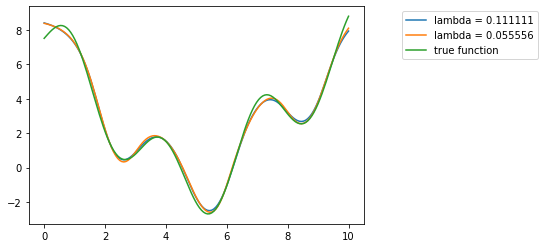

In [76]:
from more_itertools import sort_together

sorted_weights = list(sort_together([wd_errors, opt_weights])[1])
sorted_biases = list(sort_together([wd_errors, opt_biases])[1])
sorted_wd_pars = list(sort_together([wd_errors, wd_pars])[1])

for c in range(2):
    weights = sorted_weights[c]
    biases = sorted_biases[c]
    fp = neural_net(X)
    
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'lambda = %.6f' %sorted_wd_pars[c])
    
plt.plot(data_no_noise[:, [0]], data_no_noise[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()
